In [1]:
!git clone https://github.com/Yichuan0712/11785-TCR.git
import os
print(os.getcwd())
os.chdir('11785-TCR')

Cloning into '11785-TCR'...
remote: Enumerating objects: 1627, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 1627 (delta 274), reused 427 (delta 245), pack-reused 1169 (from 1)
Receiving objects: 100% (1627/1627), 5.46 MiB | 4.80 MiB/s, done.
Resolving deltas: 100% (942/942), done.
/content


In [2]:
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'
!pip install 'git+https://github.com/facebookresearch/esm.git'
!pip install peft
!pip install rdkit-pypi

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-5f9dt9av
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-5f9dt9av
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done
  Created wheel for cosine_annealing_warmup: filename=cosine_annealing_warmup-2.0-py3-none-any.whl size=4167 sha256=52320ff7f6321efb7a1220384fd088ce4f99d2e12cbecf014acc75140e41069e
  Stored in directory: /tmp/pip-ephem-wheel-cache-lodczlp2/wheels/29/26/10/bf1a07417dd54aa73bdf09ce4f31c187974a444a1cedddbd99
Successfully built cosine_annealing_warmup
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-4ew5ygff
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-4ew5ygff
  Resolved

In [3]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git pull origin main

From https://github.com/Yichuan0712/11785-TCR
 * branch            main       -> FETCH_HEAD
Already up to date.


In [5]:
import os
import pickle
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import random

import yaml
from box import Box

from model import prepare_models
from data import PytdcDatasetInfer

In [6]:
with open("/content/11785-TCR/config/final/final_clean_finetune_4.yaml") as file:
    config_dict = yaml.full_load(file)
    configs = Box(config_dict)

In [7]:
test_data = pd.read_csv(f'/content/11785-TCR/dataset/latent_space/test.csv')
test_dataset = PytdcDatasetInfer(test_data, configs)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [8]:
encoder, projection_head = prepare_models(configs, log_path=None)
device = torch.device("cuda")
encoder.to(device)
projection_head.to(device)

# checkpoint = torch.load(parse_args.resume_path, map_location='cuda:0', weights_only=False)
# encoder.load_state_dict(checkpoint['encoder_state_dict'])
# projection_head.load_state_dict(checkpoint['projection_head_state_dict'])

alphabet = encoder.alphabet
tokenizer = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [9]:
from tqdm import tqdm
import torch

device = torch.device("cuda")

encoder.eval()
projection_head.eval()

tensor_list = []
epitope_list_all = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Cluster Center Calculation")

with torch.no_grad():
    for batch, data in progress_bar:
        epitope_list = data['epitope']
        anchor_list = data['TCR']

        anchor_seq_batch = [(epitope_list[i], str(anchor_list[i])) for i in range(len(epitope_list))]
        _, _, anchor_tokens = tokenizer(anchor_seq_batch)

        print(anchor_tokens.shape)  # e.g., [107, 22]
        embeddings = encoder(anchor_tokens.to(device))
        print(embeddings.shape)  # e.g., [107, 22, 1280]

        aggregated_embeddings = embeddings.mean(dim=1)  # Shape: [107, 1280]

        tensor_list.append(aggregated_embeddings.cpu())
        epitope_list_all.extend(epitope_list)

tensor_list_combined = torch.cat(tensor_list, dim=0)

print("Tensor list shape:", tensor_list_combined.shape)  # Shape: [Total_samples, 1280]
print("Total epitopes:", len(epitope_list_all))



Cluster Center Calculation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([107, 22])


Cluster Center Calculation: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

torch.Size([107, 22, 1280])
Tensor list shape: torch.Size([107, 1280])
Total epitopes: 107


In [10]:
!cp /content/drive/MyDrive/11785-project/final/C_top4.pth /content

In [11]:
encoder, projection_head = prepare_models(configs, log_path=None)
device = torch.device("cuda")
encoder.to(device)
projection_head.to(device)

checkpoint = torch.load('/content/C_top4.pth', map_location='cuda:0', weights_only=False)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
projection_head.load_state_dict(checkpoint['projection_head_state_dict'])

alphabet = encoder.alphabet
tokenizer = alphabet.get_batch_converter()

In [12]:
from tqdm import tqdm
import torch

device = torch.device("cuda")

encoder.eval()
projection_head.eval()

tensor_list_1 = []
epitope_list_all_1 = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Cluster Center Calculation")

with torch.no_grad():
    for batch, data in progress_bar:
        epitope_list = data['epitope']
        anchor_list = data['TCR']

        anchor_seq_batch = [(epitope_list[i], str(anchor_list[i])) for i in range(len(epitope_list))]
        _, _, anchor_tokens = tokenizer(anchor_seq_batch)

        print(anchor_tokens.shape)  # e.g., [107, 22]
        embeddings = encoder(anchor_tokens.to(device))
        print(embeddings.shape)  # e.g., [107, 22, 1280]

        aggregated_embeddings = embeddings.mean(dim=1)  # Shape: [107, 1280]

        tensor_list_1.append(aggregated_embeddings.cpu())
        epitope_list_all_1.extend(epitope_list)

tensor_list_combined_1 = torch.cat(tensor_list_1, dim=0)

print("Tensor list shape:", tensor_list_combined_1.shape)  # Shape: [Total_samples, 1280]
print("Total epitopes:", len(epitope_list_all_1))


Cluster Center Calculation:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([107, 22])
torch.Size([107, 22, 1280])


Cluster Center Calculation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

Tensor list shape: torch.Size([107, 1280])
Total epitopes: 107


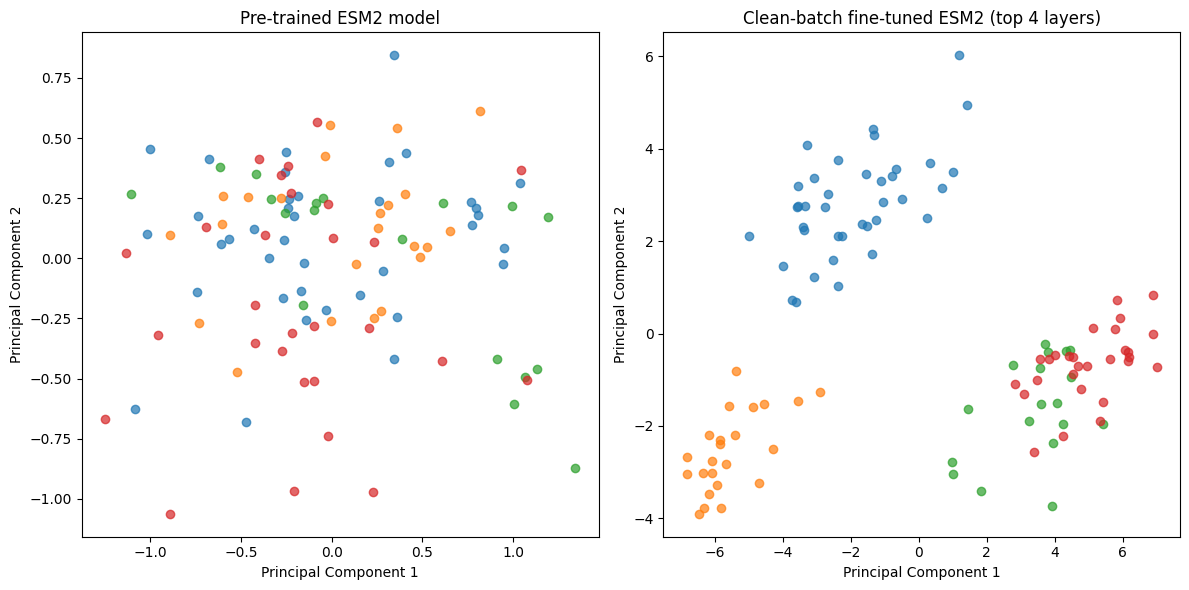

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 假设 tensor_list_combined 和 tensor_list_combined_1 是你的 [107, 1280] 张量
# epitope_list_all 是长度为 107 的列表，其中包含 4 类标签

# 手动定义颜色映射
unique_labels = list(set(epitope_list_all))  # 找出所有唯一的标签
label_to_color = {label: i for i, label in enumerate(unique_labels)}  # 将每个标签映射到一个数字
numeric_labels = [label_to_color[label] for label in epitope_list_all]  # 将标签转换为数字

# PCA 降维
pca = PCA(n_components=2)
tensor_combined_pca = pca.fit_transform(tensor_list_combined.numpy())
tensor_combined_1_pca = pca.fit_transform(tensor_list_combined_1.numpy())

# 绘制第一个 PCA 散点图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for label, color in label_to_color.items():
    indices = [i for i, lbl in enumerate(epitope_list_all) if lbl == label]
    plt.scatter(
        tensor_combined_pca[indices, 0],
        tensor_combined_pca[indices, 1],
        label=label,
        alpha=0.7
    )
plt.title('Pre-trained ESM2 model')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.legend(title="Epitope Labels")

# 绘制第二个 PCA 散点图
plt.subplot(1, 2, 2)
for label, color in label_to_color.items():
    indices = [i for i, lbl in enumerate(epitope_list_all) if lbl == label]
    plt.scatter(
        tensor_combined_1_pca[indices, 0],
        tensor_combined_1_pca[indices, 1],
        label=label,
        alpha=0.7
    )
plt.title('Clean-batch fine-tuned ESM2 (top 4 layers)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.legend(title="Epitope Labels")

plt.tight_layout()
plt.show()
